**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1) Load the dataset and perform splitting into training and validation sets with 70:30 ratio.

> Do we need to normalise data? [If so Does it make any difference?]

2) Implement the K Means algorithm. You need to find the optimal number of clusters using the
    elbow method and silhouette method. 

3) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

4) Experiment with different distance measures[Euclidean distance, Manhattan distance].

5) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.

6) Report the training and the validation accuracy and Compare your trained model with a model trained by the scikit-learn

7) Visualize the dataset to depict the clusters formed. #Prefer T-SNE

8) Implement K-means++, and repeat task 1 to task 7 again.</br>
</br>
</br>
</br>
</br>
**Part 2:**
</br>
In this task, you will perform operations on `[data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`, data.csv is a  latent space representation of  Fashion-MNIST, before doing this task please read about latent space representation.

9) Load the data.csv file and apply Kmeans and Kmeans++, You need to find the optimal number of clusters using the elbow method and silhouette method.

10) Visualize the dataset to depict the clusters formed. # Prefer T-SNE

11) From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?
</br>
</br>
**Note:** If the model takes a lot of time to train you can use MiniBatchKMeans.
 




### GYAN
Silhouette method calculates score for each point. (Refer wikipedia for more info)
after calculating for each point take the average.
Commonly used initialization methods are Forgy and Random Partition.[10] The Forgy method randomly chooses k observations from the dataset and uses these as the initial means. The Random Partition method first randomly assigns a cluster to each observation and then proceeds to the update step, thus computing the initial mean to be the centroid of the cluster's randomly assigned points. The Forgy method tends to spread the initial means out, while Random Partition places all of them close to the center of the data set. The Random Partition method is generally preferable for algorithms such as the k-harmonic means and fuzzy k-means. For expectation maximization and standard k-means algorithms, the Forgy method of initialization is preferable..

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
#implement elbow method from scratch
def elbow(X, labels, Centroids):
    pass

In [33]:
#implement silhouette method from scratch
def silhouette(X, labels, Centroids):
    pass

In [30]:
#implement Kmeans from scratch
class Kmeans:
    # initialise k clusters (Random or Forgy)
    # range can be decided based on whether data is normalized or not
    # write the iterative method for finding next clusters
    def __init__(self, X, k, init_method, normalized, iterations):
        self.init_method = init_method
        self.normalized = normalized
        self.iterations = iterations
        self.k = k
        self.X = X
        self.centroids = []
        
    def intialise(self):
        if self.init_method == 'Forgy':
            

  

In [31]:
#implement Kmeans++ from scratch
class Kmeansplusplus:

    def __init__(self):
        pass

 

In [9]:
train = pd.read_csv('fashion-mnist_train.csv')

In [12]:
y_train = train['label']

In [21]:
x_train = train.drop(['label'], axis=1)

In [22]:
x_train = x_train.to_numpy()

In [26]:
print(x_train.shape)
x_train = x_train.reshape(60000, 28, 28)

(60000, 784)


In [27]:
print(x_train.shape)

(60000, 28, 28)


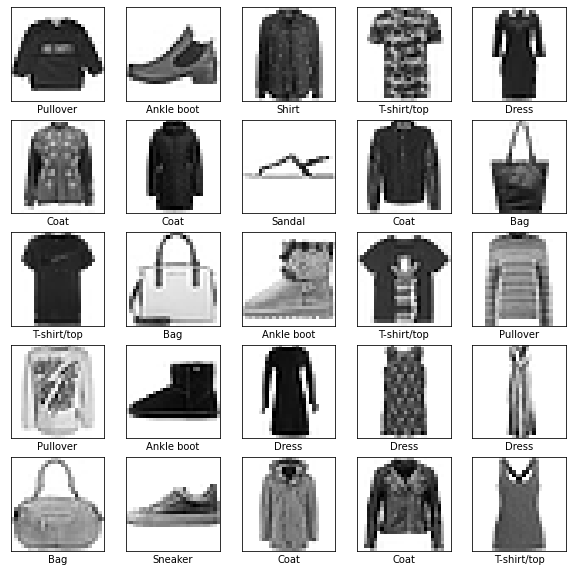

In [29]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

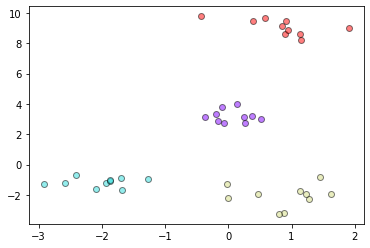

In [45]:
from sklearn.datasets import make_blobs
from matplotlib import cm
centers = [[0, 3], [-2, -1], [1, -2], [1, 9]] 
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 40, 
                            centers = centers, 
                            cluster_std = 0.5)
y_unique = np.unique(labels_true)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[labels_true == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.show()